# Continuum Subraction
This notebook along with a program called `continuum_sub.py` will demonstrate how continuum subtraction is performed on the NIRCam images of NGC 3324 from JWST.

In [1]:
# use the entire screen width for the notebook
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [2]:
# imports
import os
import sys
import glob
import numpy as np
from scipy import optimize
#
import matplotlib.pyplot as plt
import matplotlib.patches as patches
#
import warnings
warnings.filterwarnings('ignore')
#
import astropy.stats as st
from astropy.utils.masked import Masked
from astropy.io import fits
from astropy.wcs import WCS
from astropy.visualization import simple_norm, MinMaxInterval, LogStretch

# add the code folder to the sys path
sys.path.append('../code')
from reproject_combine import reproject
from continuum_sub import ContinuumSubtract

In [3]:
# Convenience function
def open_fits(fname):
    """ Convenience function for reading in fits files, getting 'SCI' data and
    header information."""
    with fits.open(fname) as hdu:
        data = hdu['SCI'].data
        header = hdu['SCI'].header
    
    return data, header

In [4]:
# make interactive plots
%matplotlib widget

In [5]:
# setup directory and filenames
directory = '/mnt/d/st_images/Carina_level3/'
cont_fname = glob.glob(directory+'*f444w_i2d.fits')[0]
narrow_fname = glob.glob(directory+'*f444w-f470n*')[0]

print('Files found:')
print(cont_fname)
print(narrow_fname)

Files found:
/mnt/d/st_images/Carina_level3/jw02731-o001_t017_nircam_clear-f444w_i2d.fits
/mnt/d/st_images/Carina_level3/jw02731-o001_t017_nircam_f444w-f470n_i2d.fits


In [6]:
# Initialise ContinuumSubtract class
c = ContinuumSubtract(narrow_fname, cont_fname)

In [7]:
# Get data/headers
f = c.get_data_headers()
c_dat, c_header = f[:2]
n_dat, n_header = f[2:]
del f # delete f object for memory consvervation

In [8]:
# Reproject images (this resizes them also for equal array shapes)
reprojected = c.reproject_continuum()

### Plotting
Now we will plot array values for the narrowband image and wideband images so that we can start deciding on a scale factor to apply to subtract the continuum from the narrowband images. To do this we will first fit a line to the narrowband data `n_dat` versus continuum data `c_dat` using `np.ma.polyfit`. Using `ma`here to accomodate masked arrays as we will be masking all 0 entries and NaN values obtained as a product of reprojection above.

In [14]:
# remove values for c_dat<=0 and c_dat=NaN by creating mask
mask = (reprojected[0]<=0) | (np.isnan(reprojected[0]))
c_dat_masked = np.ma.array(reprojected[0], mask=mask)
n_dat_masked = np.ma.masked_invalid(reprojected[1])

# flatten the data arrays for plotting
c_dat_flat = c_dat_masked.flatten()
n_dat_flat = n_dat_masked.flatten()

In [10]:
# Fit a straight line to c_dat_flat and n_dat_flat graph
def func(x, m, c):
    """ Equation of line function to be called when m (slope) and c (intersect) are obtained."""
    return m * x + c

# setup regions for continuum subtract calculations
region1 = "slice(3000,4000), slice(1000,1600)"
region2 = "slice(4000,5000), slice(3000,3600)"

m, c, c_flat, n_flat = c.get_line_params(region1, region2, reprojected[0], reprojected[1])
print('Line parameters:')
print(f'Slope: {m}', f'Intersect: {c}')

Line parameters:
Slope: 1.277342184011586 Intersect: -0.8308631576038698


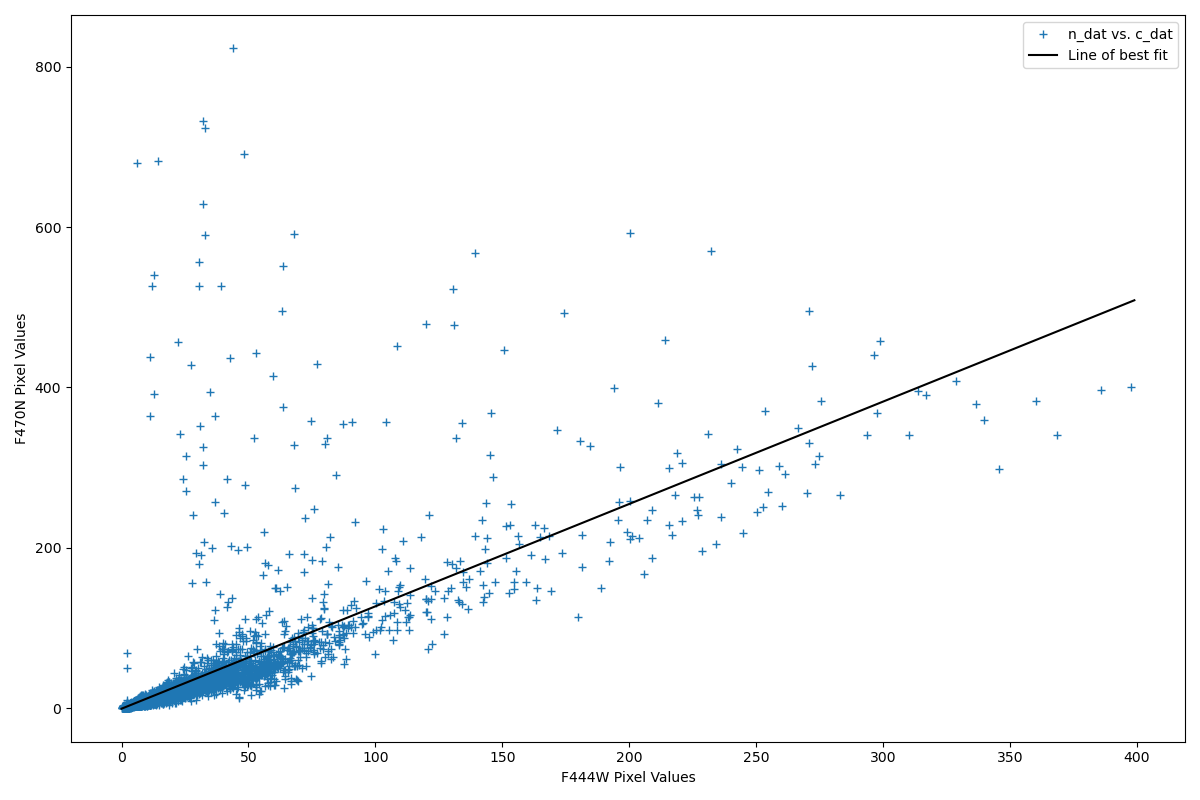

In [14]:
# Plot c_dat, n_dat with line fit
plt.figure(figsize=(12,8))
ax = plt.subplot(1,1,1)
ax.plot(c_flat, n_flat, '+', label='n_dat vs. c_dat')
x_plot = np.arange(400)
ax.plot(x_plot, func(x_plot, m, c), 'k', label='Line of best fit')
ax.set_ylabel('F470N Pixel Values')
ax.set_xlabel('F444W Pixel Values')
plt.legend(loc='best')
plt.tight_layout()

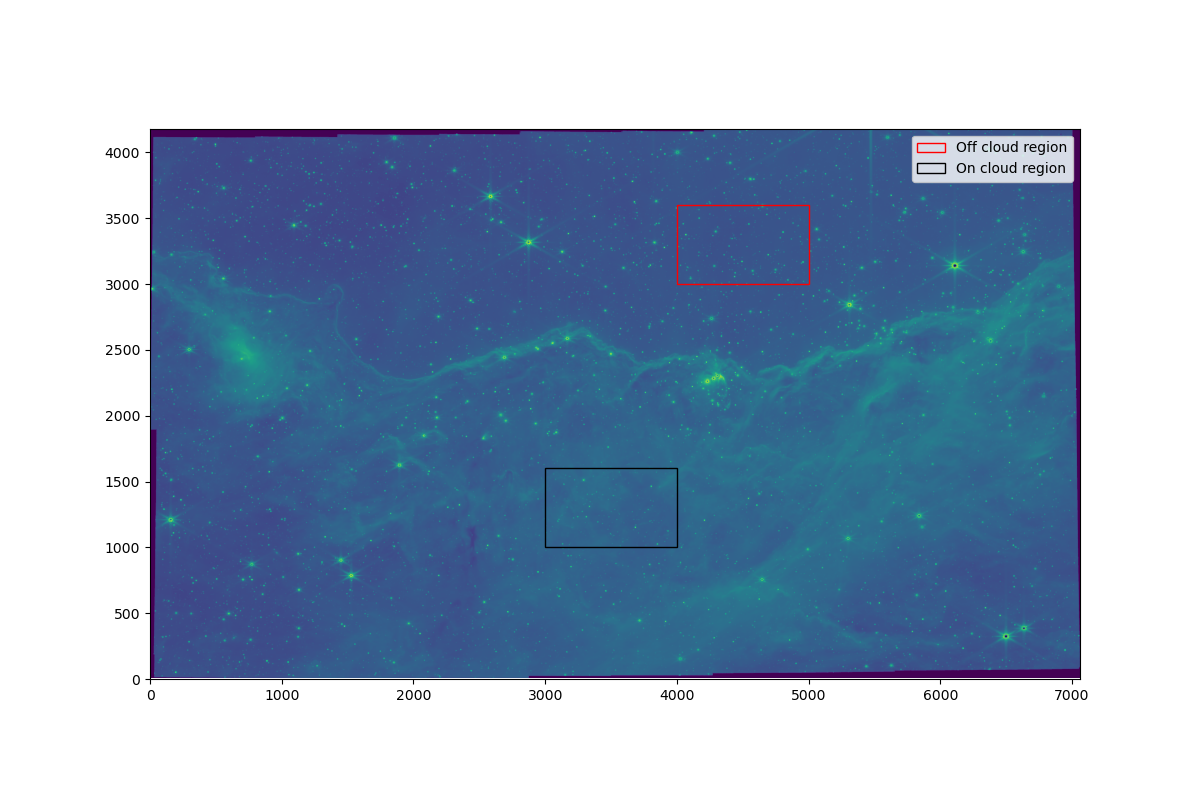

In [26]:
# Plot rectangles on image we want to use for continuum subtraction (one region on cloud and one region off)
off_cloud = patches.Rectangle((4000,3000), 1000, 600, edgecolor='r', facecolor='none', label='Off cloud region')
on_cloud = patches.Rectangle((3000, 1000), 1000, 600, edgecolor='k', facecolor='none', label='On cloud region')

norm = simple_norm(reprojected[0], stretch='log', invalid=0, min_cut=0, max_cut=500)
plt.figure(figsize=(12,8))
ax = plt.subplot(1,1,1)
ax.imshow(reprojected[0], norm=norm, origin='lower')
ax.add_patch(off_cloud)
ax.add_patch(on_cloud)
plt.legend(loc='best')

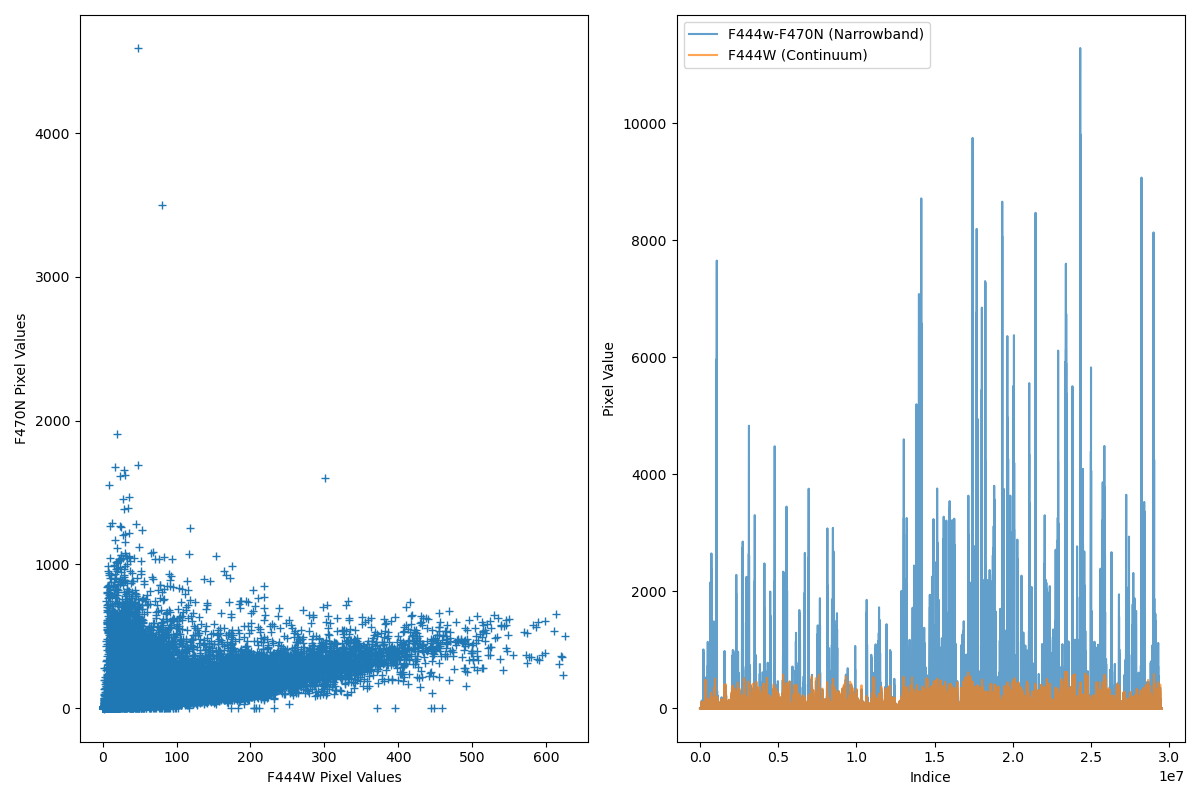

In [11]:
# Plot
plt.figure(figsize=(12,8))
ax1 = plt.subplot(1, 2, 1)
ax1.plot(c_dat_flat, n_dat_flat, '+')
ax1.set_ylabel('F470N Pixel Values')
ax1.set_xlabel('F444W Pixel Values')

ax2 = plt.subplot(1, 2, 2)
ax2.plot(n_dat_flat, alpha=0.7, label='F444w-F470N (Narrowband)')
ax2.plot(c_dat_flat, alpha=0.7, label='F444W (Continuum)')
ax2.set_ylabel('Pixel Value')
ax2.set_xlabel('Indice')
ax2.legend(loc='best')
plt.tight_layout()
plt.show()

## Filtering and removing continuum
We now need to scale the F444W image data to fit the F470N data. This should create a proportional slope in the left plot and equally scaled values in the right plot.
Furthermore, we will use sigma clipping on the subtracted image to try remove point sources such as stars from the background.

In [9]:
# Scale continuum data and subtract, then can rerun previous cell for plot
scale_factor = 2
subc = c.continuum_sub(reprojected, scale_factor)

In [20]:
import gc
gc.collect() # clean up memory

213

In [11]:
# clip array
fil_subc = st.sigma_clip(subc, sigma=30, maxiters=5)
fil_subc = fil_subc.filled(fill_value=-1) # replace masked array values with -1 for plotting

Plotting the subtracted image `subc` below. Parameters such as `max_cut` in the `norm` variable for plotting were changed to increase brightness of the outflows as needed. With decreasing `sigma` values above, details of the outflows were being lost so this is a good middle ground.

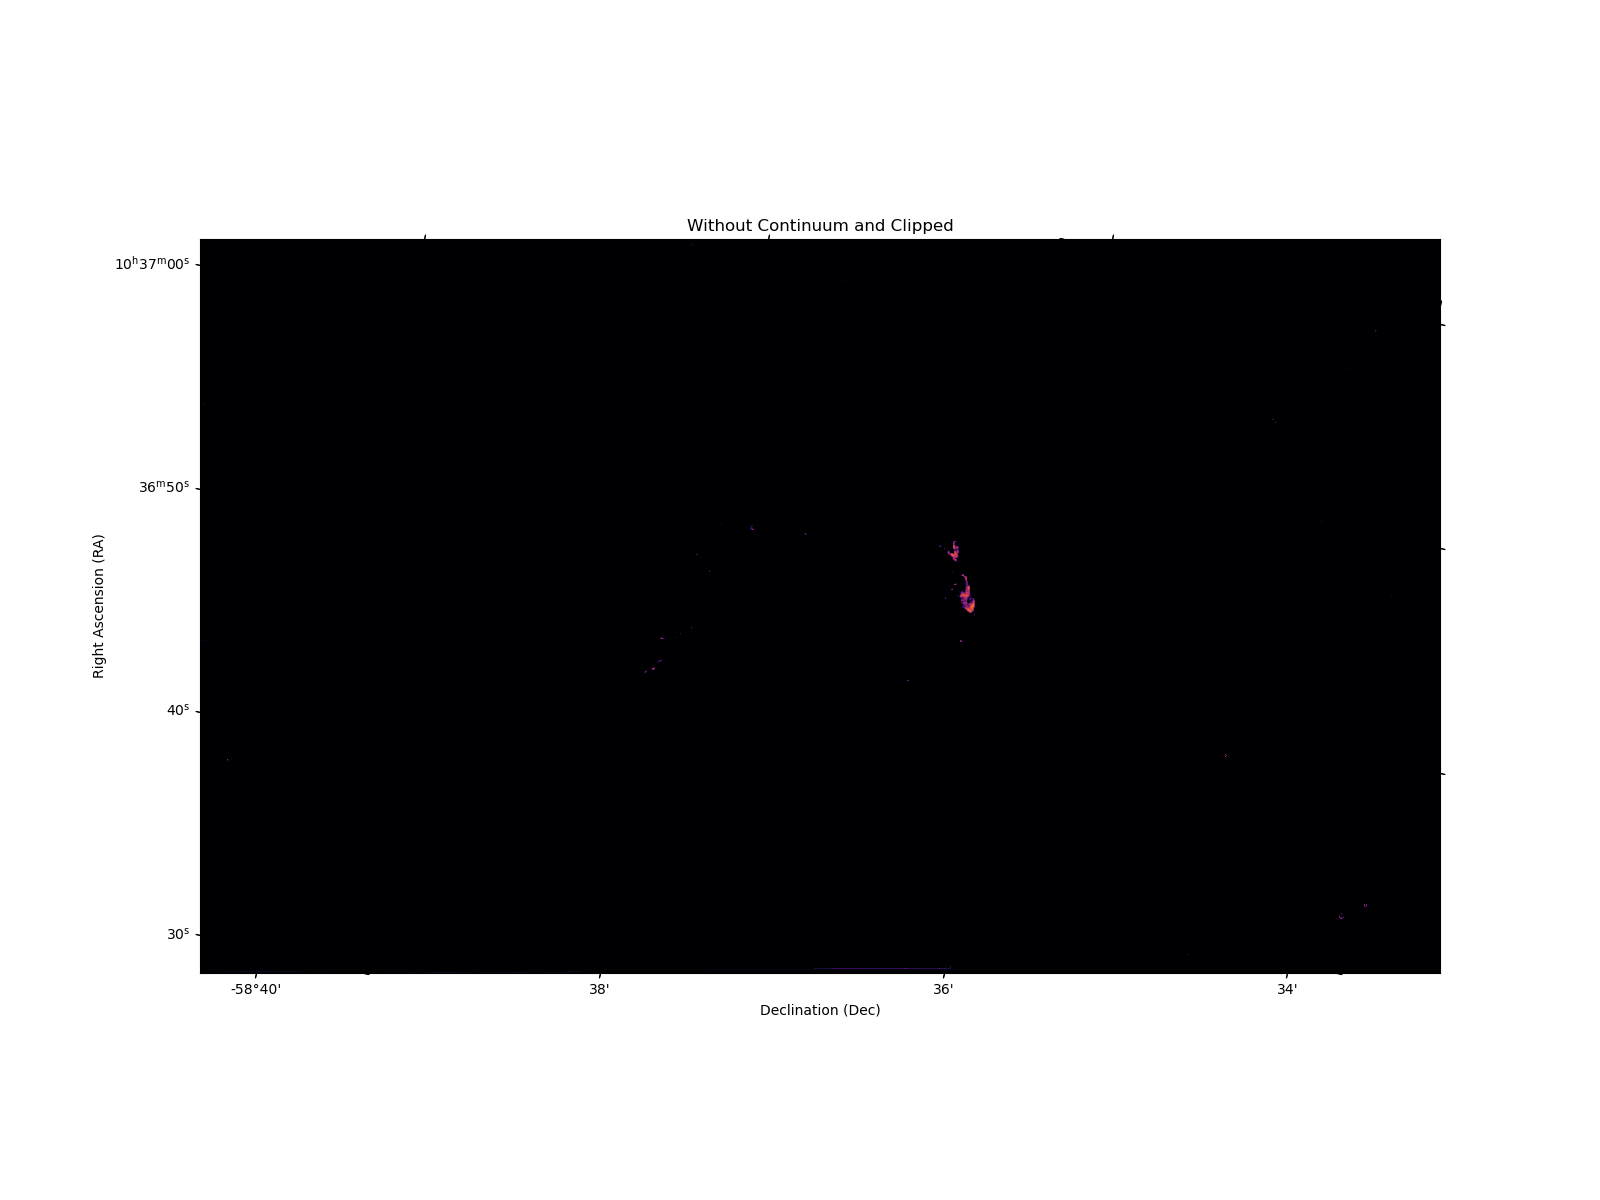

In [21]:
# Plot image with subtracted continuum
plt.figure(figsize=(16,12))
ax1 = plt.subplot(1, 1, 1, projection=WCS(n_header))
im = ax1.imshow(fil_subc, origin='lower', norm = simple_norm(subc, stretch='log', invalid=0, min_cut=0, max_cut=500), cmap='inferno')
ax1.set_title('Without Continuum and Clipped')
ax1.coords['ra'].set_ticklabel_position('l')
ax1.coords['dec'].set_ticklabel_position('b')
ax1.set_ylabel('Right Ascension (RA)', fontsize=10)
ax1.set_xlabel('Declination (Dec)', fontsize=10)
#plt.colorbar(im)

# ax2 = plt.subplot(1, 2, 2)
# im1 = ax2.imshow(reprojected[1], origin='lower', norm = simple_norm(reprojected[1], stretch='log', invalid=0, min_cut=0), 
#                 cmap='jet')
# ax2.set_title('With Continuum')
plt.tight_layout(rect=(0.09,0,0,0))

Plotting a comparison of the two images, after and before continuum subtraction.

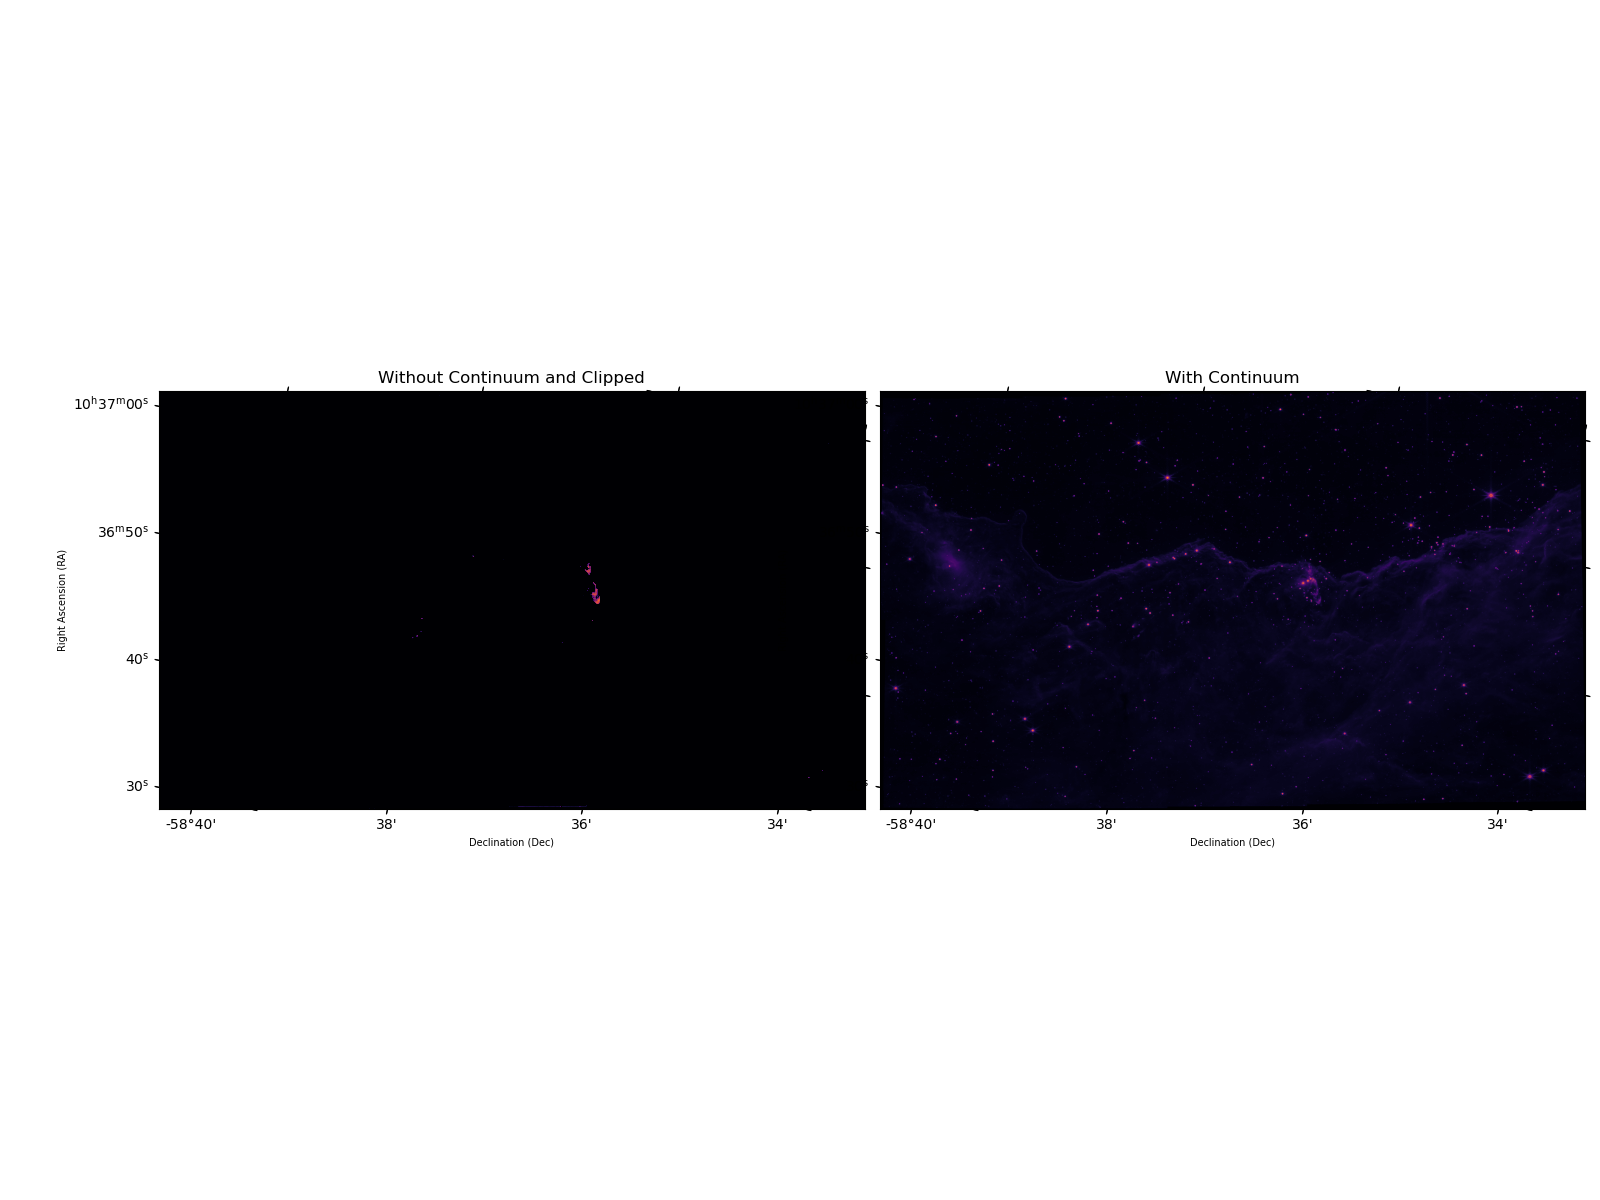

In [16]:
# Plot image with subtracted continuum
wcs = WCS(n_header)
plt.figure(figsize=(16,12))
ax1 = plt.subplot(1, 2, 1, projection=wcs)
ax1.imshow(fil_subc, origin='lower', norm = simple_norm(subc, stretch='log', invalid=0, min_cut=0, max_cut=500), cmap='inferno')
ax1.set_title('Without Continuum and Clipped')
ax1.coords['ra'].set_ticklabel_position('l')
ax1.coords['dec'].set_ticklabel_position('b')
ax1.set_ylabel('Right Ascension (RA)', fontsize=7)
ax1.set_xlabel('Declination (Dec)', fontsize=7)

ax2 = plt.subplot(1, 2, 2, projection=wcs)
ax2.imshow(reprojected[1], origin='lower', norm = simple_norm(reprojected[1], stretch='log', invalid=0, min_cut=0), 
                cmap='inferno')
ax2.set_title('With Continuum')
ax2.coords['ra'].set_ticklabel_position('l')
ax2.coords['dec'].set_ticklabel_position('b')
ax2.set_ylabel('Right Ascension (RA)', fontsize=7)
ax2.set_xlabel('Declination (Dec)', fontsize=7)
plt.tight_layout(rect=(0.09,0,1,1))